# Spatial Encoding

To create images of the net magnetization, magnetic field gradients are applied in order to modulate the resonance frequency as a function of position.  This section describes the effect of magnetic field gradients during data acquisition to create spatial encoding, including frequency encoding, phase encoding and other k-space trajectories.

## Learning Goals

1. Describe how images are formed
    * Describe the effects of gradients on the signal
    * Understand how frequency encoding works
    * Understand how phase encoding works
    * Describe what a k-space trajectory is

## Effects of Magnetic Field Gradients

Applied magnetic field gradients change the magnetic field linearly with position:

$$\Delta B_z = \vec{G}\cdot\vec{r}$$

which leads to linear variation in the resonance frequency as a function of position:

$$ \omega = \gamma \vec{G}\cdot\vec{r} $$

This forms the basis for spatial encoding.

For constant gradients, $\vec{G}(t) = \vec{G}_0$, this variation in frequency can be described by (neglecting relaxation)

$$\begin{align}
M_{XY}(\vec{r},t) & =  M_{XY}(\vec{r},0) \exp(-t/T_2(\vec{r})) \exp\left( -i \gamma \vec{G}_0 \cdot \vec{r} \ t \right) \\ 
& \approx M_{XY}(\vec{r}, 0) \exp\left( -i \gamma \vec{G}_0 \cdot \vec{r} \ t \right)
\end{align}$$


For general time-varying gradients, their effect is to create phase accumulation depending on the cumulative gradient area, or the integral of the gradient.  This means we can turn the gradients on and off to start and stop the phase accumulation, and also reverse the gradient polarity to undo any prior phase accumulation.  

$$M_{XY}(\vec{r}, t) = M_{XY}(\vec{r}, 0) \exp\left( -i \gamma \int_0^t \vec{G}(\tau) \cdot \vec{r} \ d\tau \right)$$ 

## k-space

Here, we introduce the concept of k-space, which is a simplified representation of the phase accumulation due to magnetic field gradients.  It is defined as

$$\vec{k}(t) = [k_X(t), k_Y(t), k_Z(t)]^T = \frac{\gamma}{2\pi} \int_0^t \vec{G}(\tau) \cdot \vec{r} \ d\tau$$ 

The effect of gradients on the transverse magnetization then becomes

$$M_{XY}(\vec{r}, t) = M_{XY}(\vec{r}, 0) e^{ -i 2 \pi \vec{k}(t) \cdot \vec{r} }$$ 

The specific motivation for k-space will become apparent soon, when we formulate the signal equation and see that there is a Fourier Transform.

## MRI signal

The MRI signal comes from the precession of the transverse magnetization, and thus is proportional to the transverse magnetization.  The MRI signal also comes from any precessing magnetization within the sensitive volume of the RF receive coils.  In other words, it is also not localized to a single location, but rather is summed over a volume:

$$\begin{align}
s(t) & = \int_\mathrm{Volume} M_{XY}(\vec{r},t) \ d\vec{r} \\
 & =  \int_{\textrm{Volume}} M_{XY}(\vec{r},0) \exp(-i2\pi \vec{k}(t) \cdot \vec{r}) \ d\vec{r}
 \end{align}$$ 

The amazing result here is that this describes our MRI signal in the form of a Fourier Transform:

$$\mathcal{F} \{ f(\vec{r}) \} = F(\vec{k}) = \int_{-\infty}^\infty f(\vec{r}) \exp(-i 2 \pi \vec{k} \cdot  \vec{r}) \ d\vec{r}$$

 This is the power of the k-space representation, that it describes how MRI is sampling data in the Fourier Transform domain, or the spatial frequency domain, of the object net magnetization.  In other words, MRI signals are a measure of the spatial frequencies of our object.  

This result means that, to reconstruct an image we need to put our MRI signals into their k-space location based on the applied gradients, and then use an inverse Fourier Transform.
Our signal is the Fourier Transform of the initial transverse magnetization, evaluated at a spatial frequnecy, $\vec{k}$, that is determined by the k-space trajectory, $\vec{k}(t)$:

$$ s(t) = \mathcal{F} \{ M_{XY}(\vec{r},0) \} |_{\vec{k} = \vec{k}(t)} $$


## From MRI data to images

First we use the following notation for simplification

$$m(\vec{r}) = M_{XY}(\vec{r},0)$$

$$\mathcal{F}\{ m(\vec{r}) \} = M(\vec{k})$$

The flow of the experiment and data is as follows:

1. RF excitation to create transverse magnetization, $M_{XY}(\vec{r},0)$
1. Gradients applied as $\vec{G}(t)$ and data is acquired
1. k-space locations, $\vec{k}(t)$, are determined based on the applied gradients
1. MR signal acquired represents the Fourier Transform of the transverse magnetization at the k-space location:$$ s(t) = M(\vec{k}(t))$$
1. MR signal over time is stored in a data matrix with known k-space locations to create $M(\vec{k})$
1. Inverse Fourier Transform is applied to reconstruct an image of the transverse magnetization$$\mathcal{F}^{-1}\{ M(\vec{k} )\} = m(\vec{r})$$

We have now have the incredible result that we used magnetic field gradients, the k-space framework, and appropriate acquisition and ordering of the MR signal to create an **IMAGE**!!

## Cartesian K-space (Frequency and Phase encoding, 2DFT Imaging)

By far the most common way to perform spatial encoding is using a Cartesian k-space trajectory, which the name refers to the fact that data is sampled on a regularly spaced grid in k-space.
This is also known 2DFT imaging, since we reconstruct images with an inverse 2D Fourier Transform.

It consists of 2 types of encoding:
1. Frequency encoding - one dimension is encoded using a constant gradient applied during data acquisition
1. Phase encoding - additional dimensions are encoded using gradient applied before data acquisition.  This gradient is incremented to provide complete spatial encoding.  Phase encoding is applied in 1 dimension for 2D imaging, and 2 dimensions for 3D imaging

### Frequency Encoding

Typically 1 dimension of the object is encoded using "frequency encoding".  This means that, after RF excitation, a magnetic field gradient is turned on and the signal is read out.  The frequencies present in the signal correspond to given spatial locations.  By convention, this is applied in the x-direction (but in practice can be rotated to any direction);

$$\omega = \gamma G_{xr} x$$
where $G_{xr}$ is the readout gradient amplitude.  Therefore, the position is proportional to the frequency:

$$ x = \frac{\omega}{\gamma G_{xr}}$$

From frequency encoding data alone, a 1D image can be reconstructed with an inverse Fourier Transform

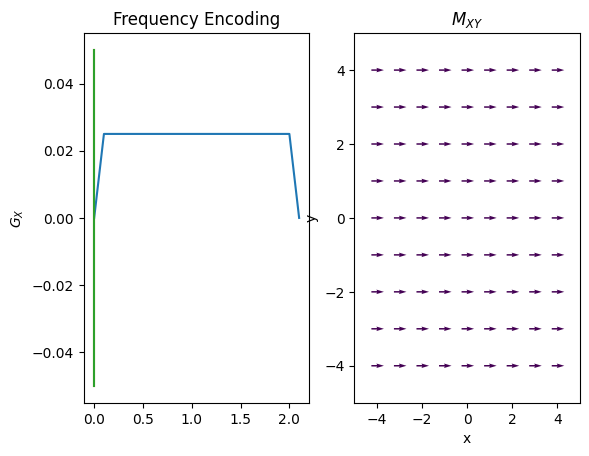

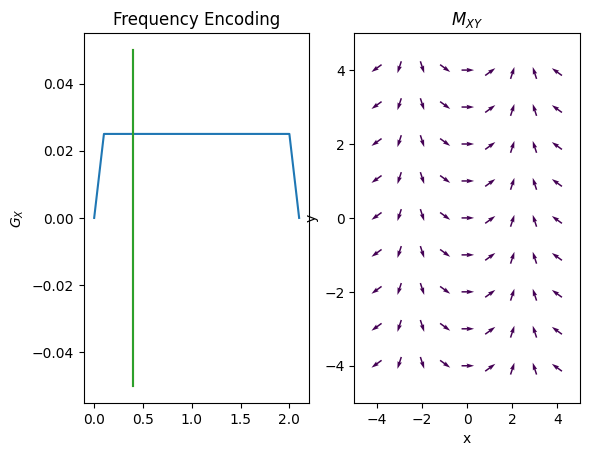

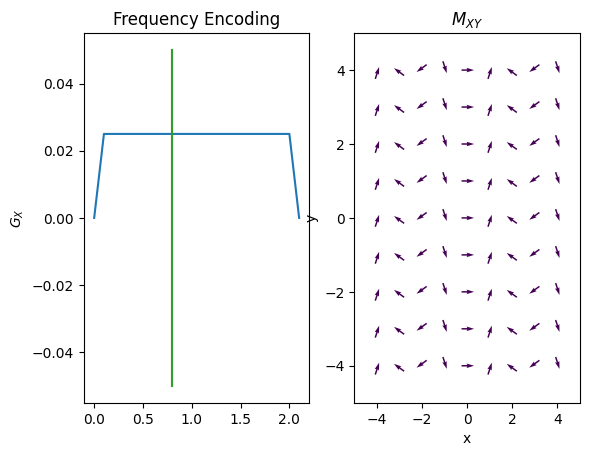

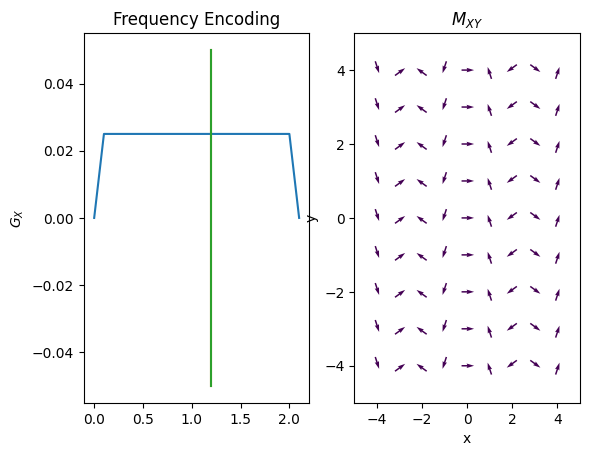

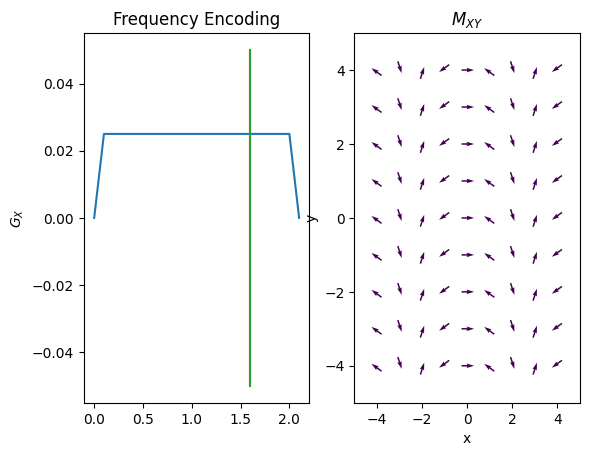

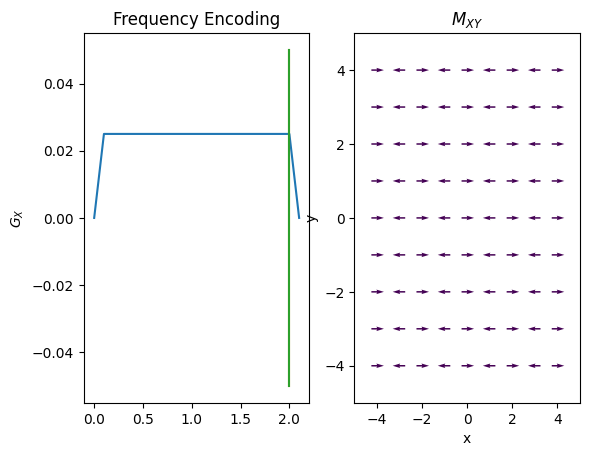

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# simulate frequency encoding
N = 8
Mxy = np.ones((N+1, N+1))

x = np.arange(-N/2, N/2+1)
x, y = np.meshgrid(x, x)
Splot = 0.5

kFE = 1/2
dt = 0.1
Tfe = 2

GAMMA = 42.58

for tfe in np.linspace(0, 1, 6) * Tfe:
    phase_x = 2 * np.pi * kFE * x * tfe / Tfe

    Mxy_FE = Mxy * np.exp(1j * phase_x)

    fig, axs = plt.subplots(1, 2)
    axs[0].plot(np.arange(0, Tfe+2*dt, dt), np.concatenate(([0], np.ones(int(Tfe/dt))*kFE/(Tfe/dt), [0])), tfe*np.ones(2), [-0.05, 0.05])
    axs[0].plot([tfe, tfe], [-0.05, 0.05])
    axs[0].set_ylabel(r'$G_X$')
    axs[0].set_title('Frequency Encoding')
    axs[1].quiver(x - np.real(Mxy_FE) * Splot/2, y - np.imag(Mxy_FE) * Splot/2, np.real(Mxy_FE), np.imag(Mxy_FE), Splot)
    axs[1].set_xlabel('x')
    axs[1].set_ylabel('y')
    axs[1].set_xlim([-N/2-1, N/2+1])
    axs[1].set_ylim([-N/2-1, N/2+1])
    axs[1].set_title(r'$M_{XY}$')
    plt.draw()
    plt.pause(0.01)

plt.show()



## Phase Encoding

Typically the 2nd (and optionally 3rd) dimensions of the object are encoded using "phase encoding".  This means that, after RF excitation but before the frequency encoding gradient, a pulsed gradient is applied such that the location is encoded in the phase of the next magnetization:

$$ \Phi = \gamma G_{yp} y t_y$$ 

These additional dimensions are fully encoded by repeating this pulsed gradient with different amplitudes.  This is equivalent to taking different samples of a frequency encoding gradient.

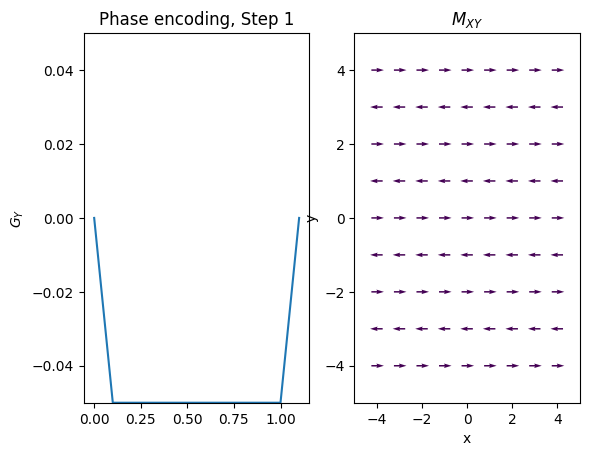

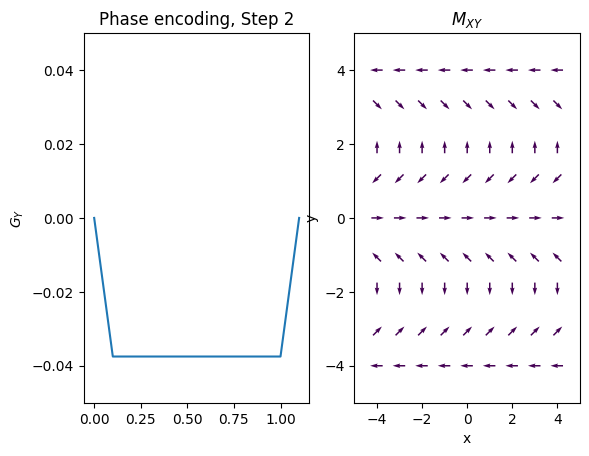

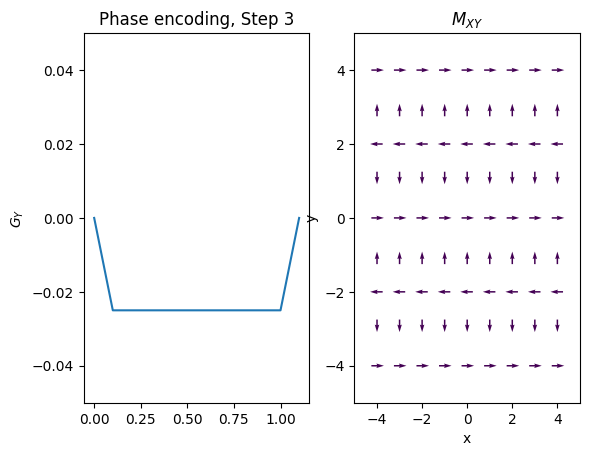

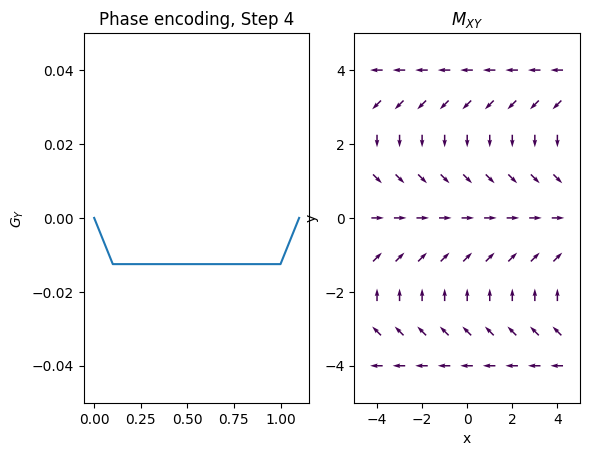

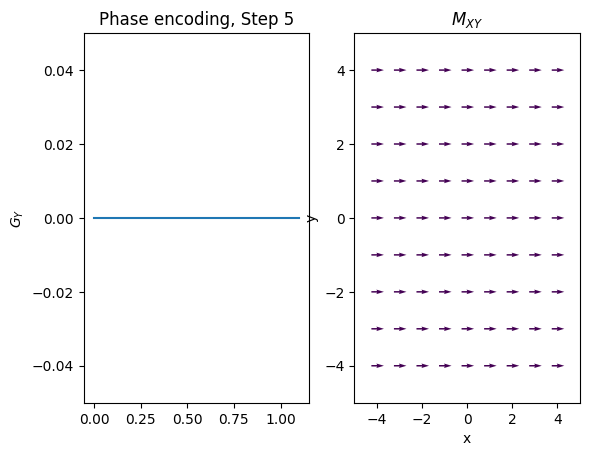

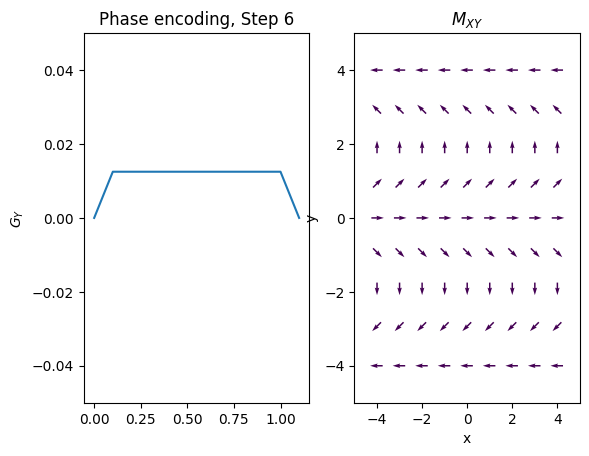

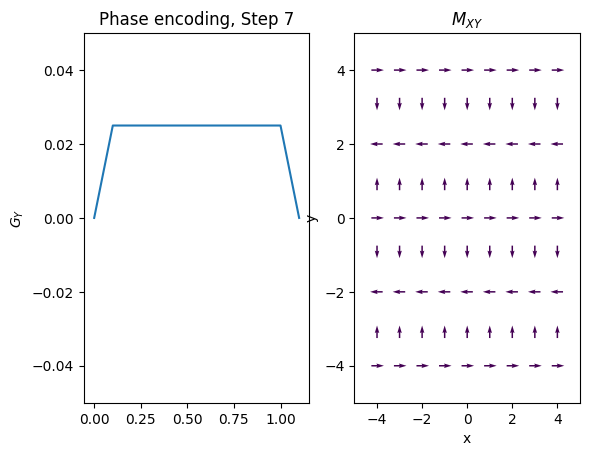

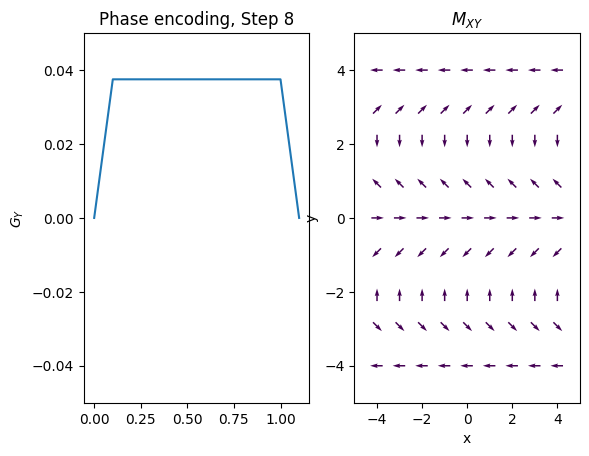

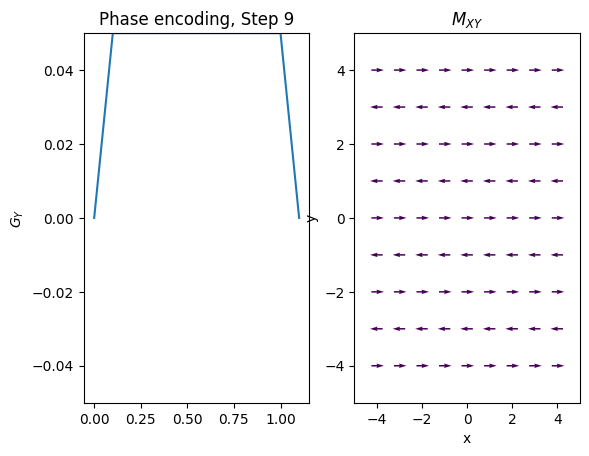

In [24]:
import numpy as np
import matplotlib.pyplot as plt

N = 8
Mxy = np.ones((N+1, N+1))

x = np.arange(-N/2, N/2+1)
x, y = np.meshgrid(x, x)
Splot = 0.5

kPE = np.arange(-N/2, N/2+1) / N
dt = 0.1
Tpe = 1

GAMMA = 42.58

for Ipe in range(len(kPE)):
    fig, axs = plt.subplots(1, 2)
    for tpe in np.arange(0, Tpe+dt, dt):
        phase_y = 2 * np.pi * kPE[Ipe] * y * tpe / Tpe
        
        Mxy_PE = Mxy * np.exp(1j * phase_y)
        
    axs[0].plot(np.arange(0, Tpe+2*dt, dt), np.concatenate(([0], np.ones(int(Tpe/dt))*kPE[Ipe]/(Tpe/dt), [0])))
    axs[0].set_ylim([-0.05, 0.05])
    axs[0].set_ylabel(r'$G_Y$')
    axs[0].set_title(f'Phase encoding, Step {Ipe+1}')
    axs[1].quiver(x - np.real(Mxy_PE) * Splot/2, y - np.imag(Mxy_PE) * Splot/2, np.real(Mxy_PE), np.imag(Mxy_PE), Splot)
    axs[1].set_xlabel('x')
    axs[1].set_ylabel('y')
    axs[1].set_xlim([-N/2-1, N/2+1])
    axs[1].set_ylim([-N/2-1, N/2+1])
    axs[1].set_title(r'$M_{XY}$')
    plt.draw()
    plt.pause(0.01)

plt.show()


## Frequency and Phase Encoding

The following simulation of the net magnetizations shows how first the phase encoding gradient ($G_Y$) creates some phase variation in $y$, and then during the frequency encoding gradient ($G_X$) the net magnetizations rotate at varying frequencies depending on their $x$ position:

![frequency_phase_encoding-simple-Mxy.gif](images/frequency_phase_encoding-simple-Mxy.gif)

Instead of viewing the net magnetizations, we can also visualize this encoding as a map of the phase of the transverse magnetization:

![frequency_phase_encoding-simple-image_phase.gif](images/frequency_phase_encoding-simple-image_phase.gif)

(See ``spatial_encoding_Mxy_illustration.m`` for code generating this movie)

## K-space Trajectories

K-space is a very general method for capturing the effect of spatial encoding gradients, and the "k-space trajectory" is defined as the pattern created over time by the gradients:

$$\vec{k}(t) = \frac{\gamma}{2\pi} \int_0^t \vec{G}(\tau) d\tau$$

Note that k-space trajectories always start at the center of k-space, $\vec{k}(0) = 0$.

The following simulation of the net magnetizations shows how rotations and k-space trajectory during a typical Cartesian (or 2D FT) gradient pulse sequence, which is differs from the simulation above in that an initial dephasing gradient in the frequency encoding direction is applied to sample both positive and negative spatial frequencies in k-space:

![frequency_phase_encoding-full-Mxy.gif](images/frequency_phase_encoding-full-Mxy.gif)

![frequency_phase_encoding-full-image_phase.gif](images/frequency_phase_encoding-full-image_phase.gif)

(See ``spatial_encoding_Mxy_illustration.m`` for code generating this movie)

### K-space trajectories

The k-space pattern during a MRI experiment is referred to as the k-space "trajectory".  The most common are Cartesian trajectories, in which parallel lines of k-space are covered to sample a 2D (or 3D) grid.  K-space trajectories with other patterns, such as radial lines, spirals, rastered lines (echo-planar trajectories), or blades can also be used. 

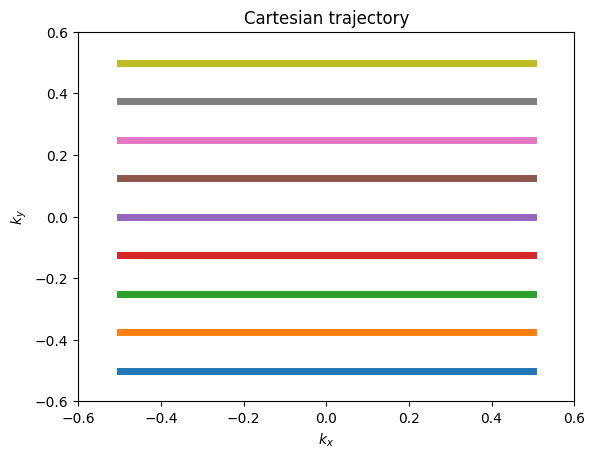

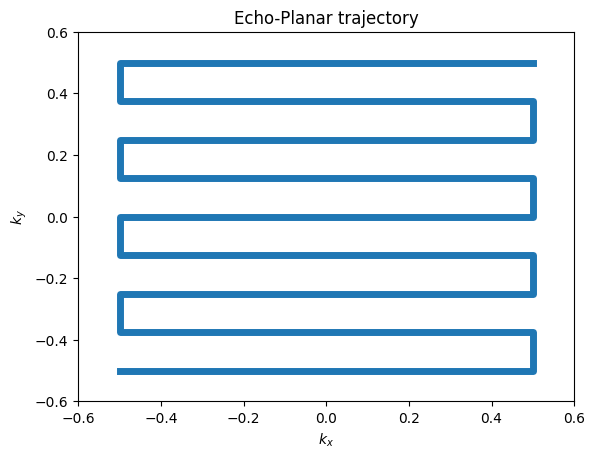

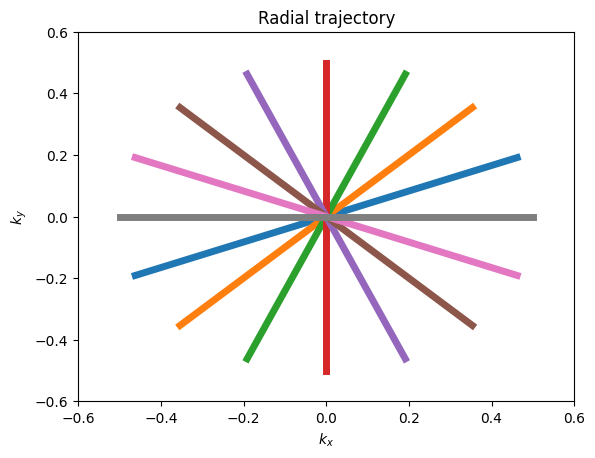

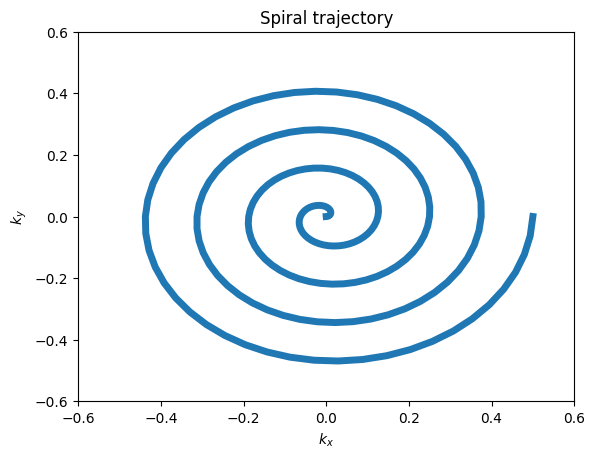

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Cartesian
N = 8

k = np.linspace(-N/2, N/2, N+1) / N
ky, kx = np.meshgrid(k, k)

plt.figure()
plt.plot(kx, ky, linewidth=5)
plt.xlim(-0.6, 0.6)
plt.ylim(-0.6, 0.6)
plt.xlabel(r'$k_x$')
plt.ylabel(r'$k_y$')
plt.title('Cartesian trajectory')

# echo-planar
kx_ep = ky.copy()
kx_ep[1::2,:] = np.flip(kx_ep[1::2,:], axis=1)
kx_ep = kx_ep.flatten()


ky_ep = kx.flatten()

plt.figure()
plt.plot(kx_ep, ky_ep, linewidth=5)
plt.xlim(-0.6, 0.6)
plt.ylim(-0.6, 0.6)
plt.xlabel(r'$k_x$')
plt.ylabel(r'$k_y$')
plt.title('Echo-Planar trajectory')

# radial
k_theta = np.exp(1j * 2 * np.pi * np.arange(1, N+1) / (2 * N))
k_radial = np.outer(k, k_theta)

plt.figure()
plt.plot(np.real(k_radial), np.imag(k_radial), linewidth=5)
plt.xlim(-0.6, 0.6)
plt.ylim(-0.6, 0.6)
plt.xlabel(r'$k_x$')
plt.ylabel(r'$k_y$')
plt.title('Radial trajectory')

# spiral
n = np.linspace(0, 1, 201)
Nturns = N / 2
k_spiral = 1/2 * n * np.exp(1j * 2 * np.pi * Nturns * n)

plt.figure()
plt.plot(np.real(k_spiral), np.imag(k_spiral), linewidth=5)
plt.xlim(-0.6, 0.6)
plt.ylim(-0.6, 0.6)
plt.xlabel(r'$k_x$')
plt.ylabel(r'$k_y$')
plt.title('Spiral trajectory')

plt.show()


These movies illustrate the phase accumulation during non-Cartesian trajectories

![radial_encoding-full-Mxy.gif](images/radial_encoding-full-Mxy.gif)

![spiral_encoding-full-Mxy.gif](images/spiral_encoding-full-Mxy.gif)

(See ``spatial_encoding_Mxy_illustration.m`` for code generating this movie)